In [1]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from shap.datasets import adult
from ensemble import utils, Ensemble

In [2]:
# Load data
X, Y = adult()
X = X.values
Y = Y.astype(int)
print(f'X.shape = {X.shape}, Y.shape = {Y.shape}')

# Split into training, val, test
val_portion = 0.2
test_portion = 0.2

# Shuffle inds
np.random.seed(0)
inds = np.arange(len(X))
np.random.shuffle(inds)
num_val = int(len(X) * val_portion)
num_test = int(len(X) * test_portion)

# Apply split
X_val, Y_val = X[:num_val], Y[:num_val]
X_test, Y_test = X[num_val:num_val+num_test], Y[num_val:num_val+num_test]
X_train, Y_train = X[num_val+num_test:], Y[num_val+num_test:]
del X, Y
print(f'train examples = {len(X_train)}, val examples = {len(X_val)}, test examples = {len(X_test)}')

X.shape = (32561, 12), Y.shape = (32561,)
train examples = 19537, val examples = 6512, test examples = 6512


In [3]:
# Train models
np.random.seed(0)
num_features = 5
num_models = 10  # 10
models = []
for seed in range(num_models):
    # Generate feature mask
    inds = np.random.choice(X_train.shape[1], num_features, replace=False)
    mask = np.zeros(X_train.shape[1])
    mask[inds] = 1

    # Create LGBM datasets
    d_train = lgb.Dataset(X_train * mask, label=Y_train)
    d_val = lgb.Dataset(X_val * mask, label=Y_val)

    # Model parameters
    params = {
        'max_bin': 512,
        'learning_rate': 0.1,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 8,
        'verbose': -1,
        'min_data': 100,
        'boost_from_average': True,
        'random_state': seed
    }
    
    # Train
    model = lgb.train(params, d_train, num_boost_round=200, valid_sets=[d_val], early_stopping_rounds=50, verbose_eval=0)
    models.append(model)

In [4]:
# Calculate performance metrics for each model
for model in models:
    # Training performance
    preds = model.predict(X_train)
    train_loss = utils.log_loss(preds, Y_train)
    train_acc = utils.accuracy(preds, Y_train)

    # Validation performance
    preds = model.predict(X_val)
    val_loss = utils.log_loss(preds, Y_val)
    val_acc = utils.accuracy(preds, Y_val)
    print(f'Train loss = {train_loss:.2f}, train acc = {100 * train_acc:.2f}, val loss = {val_loss:.2f}, val acc = {100 * val_acc:.2f}')

Train loss = 0.43, train acc = 79.85, val loss = 0.45, val acc = 78.99
Train loss = 0.34, train acc = 84.12, val loss = 0.35, val acc = 83.08
Train loss = 0.43, train acc = 80.45, val loss = 0.45, val acc = 79.51
Train loss = 0.29, train acc = 86.71, val loss = 0.30, val acc = 85.92
Train loss = 0.38, train acc = 80.65, val loss = 0.38, val acc = 80.57
Train loss = 0.30, train acc = 86.20, val loss = 0.32, val acc = 85.33
Train loss = 0.34, train acc = 84.00, val loss = 0.35, val acc = 83.15
Train loss = 0.43, train acc = 80.85, val loss = 0.44, val acc = 79.71
Train loss = 0.41, train acc = 80.43, val loss = 0.42, val acc = 79.53
Train loss = 0.41, train acc = 82.86, val loss = 0.42, val acc = 82.86


In [5]:
# Aggregate validation and test predictions
val_preds = {f'LGBM ({i})': model.predict(X_val) for i, model in enumerate(models)}
test_preds = {f'LGBM ({i})': model.predict(X_test) for i, model in enumerate(models)}

# Evaluate models in isolation
val_loss = {name: utils.log_loss(preds, Y_val) for name, preds in val_preds.items()}
val_acc = {name: utils.accuracy(preds, Y_val) for name, preds in val_preds.items()}
test_loss = {name: utils.log_loss(preds, Y_test) for name, preds in test_preds.items()}
test_acc = {name: utils.accuracy(preds, Y_test) for name, preds in test_preds.items()}

In [6]:
# Create ensemble
# TODO this solver is currently failing
# ensemble = Ensemble('binary:logloss_probs', 'simplex')
ensemble = Ensemble('binary:logloss_logits', 'simplex', input_transform='logit', output_transform='sigmoid')

# Generate predictions using uniform weighting
ensemble_val_preds = ensemble.predict(val_preds.values())
ensemble_test_preds = ensemble.predict(test_preds.values())

In [7]:
# Evaluate simple ensemble
ensemble_val_loss = utils.log_loss(ensemble_val_preds, Y_val)
ensemble_val_acc = utils.accuracy(ensemble_val_preds, Y_val)
val_loss['Uniform Ensemble'] = ensemble_val_loss
val_acc['Uniform Ensemble'] = ensemble_val_acc

ensemble_test_loss = utils.log_loss(ensemble_test_preds, Y_test)
ensemble_test_acc = utils.accuracy(ensemble_test_preds, Y_test)
test_loss['Uniform Ensemble'] = ensemble_test_loss
test_acc['Uniform Ensemble'] = ensemble_test_acc

In [8]:
# Fit the ensemble
ensemble.fit(list(val_preds.values()), Y_val)

# Generate validation and test predictions
ensemble_val_preds = ensemble.predict(val_preds.values())
ensemble_test_preds = ensemble.predict(test_preds.values())

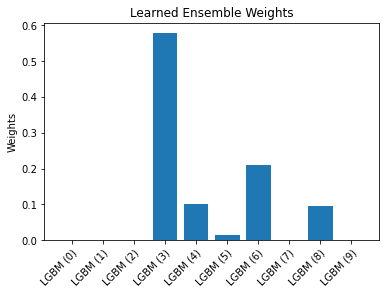

In [9]:
# Plot learned weights
plt.figure()
plt.bar(range(len(models)), ensemble.weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.ylabel('Weights')
plt.show()

In [10]:
# Evaluate learned ensemble
ensemble_val_loss = utils.log_loss(ensemble_val_preds, Y_val)
ensemble_val_acc = utils.accuracy(ensemble_val_preds, Y_val)
val_loss['Learned Ensemble'] = ensemble_val_loss
val_acc['Learned Ensemble'] = ensemble_val_acc

ensemble_test_loss = utils.log_loss(ensemble_test_preds, Y_test)
ensemble_test_acc = utils.accuracy(ensemble_test_preds, Y_test)
test_loss['Learned Ensemble'] = ensemble_test_loss
test_acc['Learned Ensemble'] = ensemble_test_acc

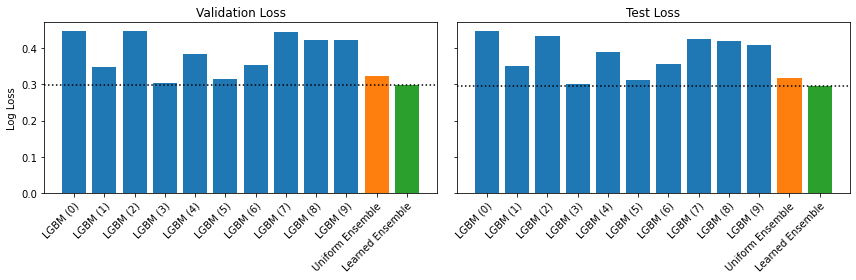

In [11]:
# Plot performance
fig, axarr = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plt.sca(axarr[0])
plt.bar(range(len(val_loss)), val_loss.values(),
        color=['C0' for _ in range(len(val_loss) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(val_loss)), val_loss.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(val_loss['Learned Ensemble'], linestyle=':', color='black')
plt.ylabel('Log Loss')
plt.title('Validation Loss')

plt.sca(axarr[1])
plt.bar(range(len(test_loss)), test_loss.values(),
        color=['C0' for _ in range(len(test_loss) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(test_loss)), test_loss.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(test_loss['Learned Ensemble'], linestyle=':', color='black')
plt.title('Test Loss')

plt.tight_layout()
plt.show()

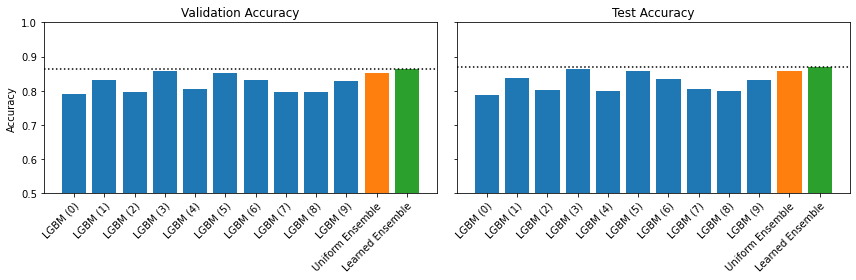

In [12]:
# Plot performance
fig, axarr = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plt.sca(axarr[0])
plt.bar(range(len(val_acc)), val_acc.values(),
        color=['C0' for _ in range(len(val_acc) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(val_acc)), val_acc.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(val_acc['Learned Ensemble'], linestyle=':', color='black')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.sca(axarr[1])
plt.bar(range(len(test_acc)), test_acc.values(),
        color=['C0' for _ in range(len(test_acc) - 2)] + ['C1', 'C2'])
plt.xticks(range(len(test_acc)), test_acc.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.axhline(test_acc['Learned Ensemble'], linestyle=':', color='black')
plt.title('Test Accuracy')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()